In [2]:
import spectral
import numpy as np
import os
from spectral.io import envi
import pandas as pd
import rasterio
import matplotlib.pyplot as plt

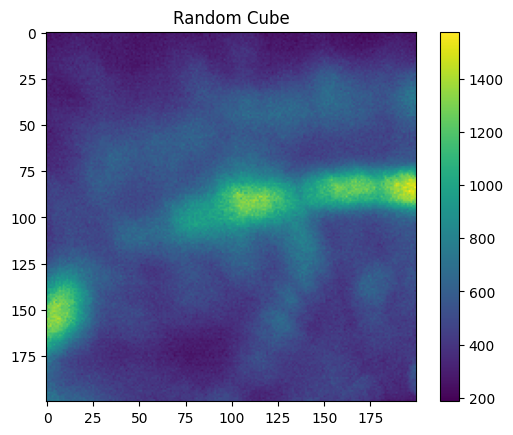

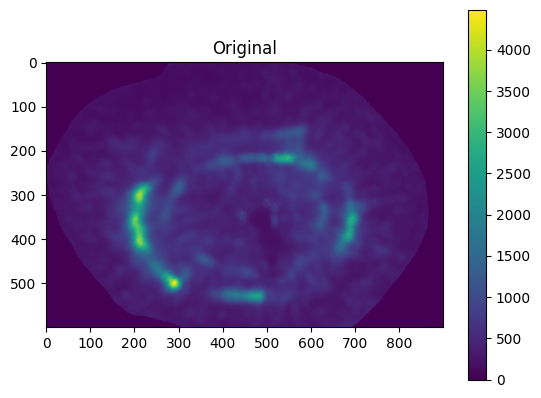

In [8]:

hsi_data = 'C:/Users/rafin/Desktop/NSU/NSU 12th Semester/CSE499A.22/Project/Datasets/Apple_Datasets/Apple_BIL/Apple_BIL_Cubes/Fungicide_Apple/DIB_AppleNativohigh/A1_H1_cube_1.bil'

# Open the BIL file using Rasterio
with rasterio.open(hsi_data) as dataset:
    
    # Read a band (for visualization purposes)
    band1 = dataset.read(30)
    
    # Visualize the first band
    plt.imshow(band1)
    plt.colorbar()
    plt.title('Random Cube')
    plt.show()
    

hsi_data = 'C:/Users/rafin/Desktop/NSU/NSU 12th Semester/CSE499A.22/Project/Datasets/Apple_Datasets/Apple_BIL/Apple_BIL_Masked/Fungicide_Apple/DIB_AppleNativohigh/A1_H1.bil'

# Open the BIL file using Rasterio
with rasterio.open(hsi_data) as dataset:
    
    band = dataset.read(30)
    
    # Visualize the first band
    plt.imshow(band)
    plt.colorbar()
    plt.title('Original')
    plt.show()

In [3]:
def calculate_mean_spectrum(image_data):
    
    """Calculate the mean spectrum across all spatial pixels."""
    
    return np.mean(image_data, axis=(0, 1))  # 1D array (300,)



def reshape_spectrum(mean_spectrum):
    
    """Reshape the mean spectrum to (1, 1, 300)."""
    
    return mean_spectrum.reshape((1, 1, len(mean_spectrum)))  # (1, 1, 300)



def save_spectrum(mean_spectrum, hdr_data, output_spec_path, output_hdr_path):
    
    """Save the mean spectrum as a .spec file with .spec.hdr."""
    
    # Reshape mean spectrum to (1, 1, 300)
    mean_spectrum_reshaped = reshape_spectrum(mean_spectrum)
    
    # Save the mean spectrum data (.spec)
    mean_spectrum_reshaped.tofile(output_spec_path)  # Save as a binary file
    
    # Modify and save the header file (.spec.hdr)
    hdr_data['lines'] = 1  # 1 line
    hdr_data['samples'] = 1  # 1 sample
    hdr_data['bands'] = len(mean_spectrum)  # 300 bands
    
    
    envi.write_envi_header(output_hdr_path, hdr_data)



def create_output_structure(input_folder, output_base_folder, current_file):
    
    """Create the corresponding output folder structure."""
    
    relative_path = os.path.relpath(current_file, input_folder)
    relative_folder = os.path.dirname(relative_path)
    
    output_folder = os.path.join(output_base_folder, relative_folder)
    os.makedirs(output_folder, exist_ok=True)
    
    return output_folder



def process_hsi_images(input_folder, output_base_folder):
    
    """Recursively traverse the folder structure, load HSI images, and save the mean spectrum."""
    
    for root, dirs, files in os.walk(input_folder):
        
        for file in files:
            
            if file.endswith('.bil'):
                
                # Get the .bil and .bil.hdr file paths
                bil_path = os.path.join(root, file)
                hdr_path = bil_path + '.hdr'
                
                # Load the hyperspectral image
                img = envi.open(hdr_path, bil_path)
                image_data = img.load()  # This will be a numpy array
                
                # Calculate the mean spectrum
                mean_spectrum = calculate_mean_spectrum(image_data)
                
                # Create corresponding output folder structure
                output_folder = create_output_structure(input_folder, output_base_folder, bil_path)
                
                # Correctly define the output .spec and .spec.hdr file paths in the new structure
                output_spec_path = os.path.join(output_folder, file.replace('.bil', '.spec'))
                output_hdr_path = os.path.join(output_folder, file.replace('.bil', '.spec.hdr'))
                
                # Save the mean spectrum
                save_spectrum(mean_spectrum, img.metadata, output_spec_path, output_hdr_path)
                
                print(f"Processed: {bil_path} -> {output_spec_path}")

if __name__ == "__main__":
    
    input_folder = 'C:/Users/rafin/Desktop/NSU/NSU 12th Semester/CSE499A.22/Project/Datasets/Apple_Datasets/Apple_BIL/Apple_BIL_Cubes'
    output_base_folder = 'C:/Users/rafin/Desktop/NSU/NSU 12th Semester/CSE499A.22/Project/Datasets/Apple_Datasets/Apple_BIL/Apple_BIL_Cubes_SM'
    
    process_hsi_images(input_folder, output_base_folder)

Processed: C:/Users/rafin/Desktop/NSU/NSU 12th Semester/CSE499A.22/Project/Datasets/Apple_Datasets/Apple_BIL/Apple_BIL_Cubes\Apple_samples\Monostar\Fresh\1_1PU_cube_1.bil -> C:/Users/rafin/Desktop/NSU/NSU 12th Semester/CSE499A.22/Project/Datasets/Apple_Datasets/Apple_BIL/Apple_BIL_Cubes_SM\Apple_samples\Monostar\Fresh\1_1PU_cube_1.spec
Processed: C:/Users/rafin/Desktop/NSU/NSU 12th Semester/CSE499A.22/Project/Datasets/Apple_Datasets/Apple_BIL/Apple_BIL_Cubes\Apple_samples\Monostar\Fresh\1_1PU_cube_10.bil -> C:/Users/rafin/Desktop/NSU/NSU 12th Semester/CSE499A.22/Project/Datasets/Apple_Datasets/Apple_BIL/Apple_BIL_Cubes_SM\Apple_samples\Monostar\Fresh\1_1PU_cube_10.spec
Processed: C:/Users/rafin/Desktop/NSU/NSU 12th Semester/CSE499A.22/Project/Datasets/Apple_Datasets/Apple_BIL/Apple_BIL_Cubes\Apple_samples\Monostar\Fresh\1_1PU_cube_11.bil -> C:/Users/rafin/Desktop/NSU/NSU 12th Semester/CSE499A.22/Project/Datasets/Apple_Datasets/Apple_BIL/Apple_BIL_Cubes_SM\Apple_samples\Monostar\Fresh\1

In [4]:
#convert to .npy

def load_and_reshape_spec(spec_file, hdr_file):
    
    """Load the .spec file and reshape the data from (1, 1, 300) to (1, 300)."""
    
    # Load the .spec file using numpy
    
    data = np.fromfile(spec_file, dtype=np.float32)
    
    # Get the metadata from the .spec.hdr file
    hdr_data = envi.read_envi_header(hdr_file)
    
    # Check if the data shape is (1, 1, 300)
    lines = int(hdr_data['lines'])       # Should be 1
    samples = int(hdr_data['samples'])   # Should be 1
    bands = int(hdr_data['bands'])       # Should be 300
    
    if lines == 1 and samples == 1 and bands == len(data):
        
        # Reshape to (1, 1, 300)
        data = data.reshape((lines, samples, bands))
        
        # Reshape to (1, 300)
        reshaped_data = data.reshape((1, bands))
        
    else:
        
        raise ValueError(f"Unexpected shape in {spec_file}: expected (1, 1, 300), got {(lines, samples, bands)}")
    
    
    return reshaped_data



def create_output_structure(input_folder, output_base_folder, current_file):
    
    """Create the corresponding output folder structure in the output directory."""
    
    relative_path = os.path.relpath(current_file, input_folder)
    relative_folder = os.path.dirname(relative_path)
    
    output_folder = os.path.join(output_base_folder, relative_folder)
    os.makedirs(output_folder, exist_ok=True)
    
    
    return output_folder



def process_spec_files(input_folder, output_base_folder):
    
    """Traverse the folder structure, convert .spec and .spec.hdr files to .npy, and save them."""
    for root, dirs, files in os.walk(input_folder):
        
        for file in files:
            
            if file.endswith('.spec'):
                
                # Get the corresponding .spec and .spec.hdr paths
                spec_file = os.path.join(root, file)
                hdr_file = spec_file + '.hdr'
                
                if not os.path.exists(hdr_file):
                    print(f"Header file missing for {spec_file}, skipping.")
                    
                    continue
                
                
                # Load and reshape the .spec file
                try:
                    
                    reshaped_data = load_and_reshape_spec(spec_file, hdr_file)
                    
                except ValueError as e:
                    
                    print(f"Error processing {spec_file}: {e}")
                    
                    continue
                
                # Create corresponding output folder structure
                output_folder = create_output_structure(input_folder, output_base_folder, spec_file)
                
                # Define the output .npy file path
                output_npy_path = os.path.join(output_folder, file.replace('.spec', '.npy'))
                
                # Save the reshaped data as a .npy file
                np.save(output_npy_path, reshaped_data)
                
                print(f"Processed: {spec_file} -> {output_npy_path}")



if __name__ == "__main__":
    
    input_folder = 'C:/Users/rafin/Desktop/NSU/NSU 12th Semester/CSE499A.22/Project/Datasets/Apple_Datasets/Apple_BIL/Apple_BIL_Cubes_SM'
    output_base_folder = 'C:/Users/rafin/Desktop/NSU/NSU 12th Semester/CSE499A.22/Project/Datasets/Apple_Datasets/Apple_BIL/Apple_BIL_Cubes_SM_npy'
    process_spec_files(input_folder, output_base_folder)

Processed: C:/Users/rafin/Desktop/NSU/NSU 12th Semester/CSE499A.22/Project/Datasets/Apple_Datasets/Apple_BIL/Apple_BIL_Cubes_SM\Apple_samples\Monostar\Fresh\1_1PU_cube_1.spec -> C:/Users/rafin/Desktop/NSU/NSU 12th Semester/CSE499A.22/Project/Datasets/Apple_Datasets/Apple_BIL/Apple_BIL_Cubes_SM_npy\Apple_samples\Monostar\Fresh\1_1PU_cube_1.npy
Processed: C:/Users/rafin/Desktop/NSU/NSU 12th Semester/CSE499A.22/Project/Datasets/Apple_Datasets/Apple_BIL/Apple_BIL_Cubes_SM\Apple_samples\Monostar\Fresh\1_1PU_cube_10.spec -> C:/Users/rafin/Desktop/NSU/NSU 12th Semester/CSE499A.22/Project/Datasets/Apple_Datasets/Apple_BIL/Apple_BIL_Cubes_SM_npy\Apple_samples\Monostar\Fresh\1_1PU_cube_10.npy
Processed: C:/Users/rafin/Desktop/NSU/NSU 12th Semester/CSE499A.22/Project/Datasets/Apple_Datasets/Apple_BIL/Apple_BIL_Cubes_SM\Apple_samples\Monostar\Fresh\1_1PU_cube_11.spec -> C:/Users/rafin/Desktop/NSU/NSU 12th Semester/CSE499A.22/Project/Datasets/Apple_Datasets/Apple_BIL/Apple_BIL_Cubes_SM_npy\Apple_sa

In [ ]:
data = np.load('C:/Users/rafin/Desktop/NSU/NSU 12th Semester/CSE499A.22/Project/Datasets/Apple_Datasets/Apple_Spectral_Means_npy/Pesticide_Apple/Pesticide_high/MA1_H2.npy')

print(data)
print(data.shape)

In [11]:
#Labels
output_directory = 'C:/Users/rafin/Desktop/NSU/NSU 12th Semester/CSE499A.22/Project/Datasets/Apple_Datasets/Apple_BIL/Apple_BIL_Cubes_SM_npy'

# Initialize a dictionary for labels
labels = {}

for root, dirs, files in os.walk(output_directory):
    
    for file in files:
        
        if file.endswith('.npy'):
            
            # Full file path
            npy_file_path = os.path.join(root, file)
            
            # Load the NumPy array
            data = np.load(npy_file_path)
            
            # Extract the label from the folder name
            folder_name = os.path.basename(root)
            
            labels[npy_file_path] = folder_name  # Store the label


# Print all labels
print("Labels assigned based on folder names:")

for npy_file, label in labels.items():
    
    print(f"{npy_file}: {label}")

Labels assigned based on folder names:
C:/Users/rafin/Desktop/NSU/NSU 12th Semester/CSE499A.22/Project/Datasets/Apple_Datasets/Apple_BIL/Apple_BIL_Cubes_SM_npy\Apple_samples\Fresh\1_1HG_cube_1.npy: Fresh
C:/Users/rafin/Desktop/NSU/NSU 12th Semester/CSE499A.22/Project/Datasets/Apple_Datasets/Apple_BIL/Apple_BIL_Cubes_SM_npy\Apple_samples\Fresh\1_1HG_cube_10.npy: Fresh
C:/Users/rafin/Desktop/NSU/NSU 12th Semester/CSE499A.22/Project/Datasets/Apple_Datasets/Apple_BIL/Apple_BIL_Cubes_SM_npy\Apple_samples\Fresh\1_1HG_cube_11.npy: Fresh
C:/Users/rafin/Desktop/NSU/NSU 12th Semester/CSE499A.22/Project/Datasets/Apple_Datasets/Apple_BIL/Apple_BIL_Cubes_SM_npy\Apple_samples\Fresh\1_1HG_cube_12.npy: Fresh
C:/Users/rafin/Desktop/NSU/NSU 12th Semester/CSE499A.22/Project/Datasets/Apple_Datasets/Apple_BIL/Apple_BIL_Cubes_SM_npy\Apple_samples\Fresh\1_1HG_cube_13.npy: Fresh
C:/Users/rafin/Desktop/NSU/NSU 12th Semester/CSE499A.22/Project/Datasets/Apple_Datasets/Apple_BIL/Apple_BIL_Cubes_SM_npy\Apple_sampl

In [8]:
print(labels)

{'C:/Users/rafin/Desktop/NSU/NSU 12th Semester/CSE499A.22/Project/Datasets/Apple_Datasets/Apple_BIL/test_npy\\Apple_samples\\Monostar\\Fresh\\1_1PU_cube_1.npy': 'Fresh', 'C:/Users/rafin/Desktop/NSU/NSU 12th Semester/CSE499A.22/Project/Datasets/Apple_Datasets/Apple_BIL/test_npy\\Apple_samples\\Monostar\\Fresh\\1_1PU_cube_2.npy': 'Fresh', 'C:/Users/rafin/Desktop/NSU/NSU 12th Semester/CSE499A.22/Project/Datasets/Apple_Datasets/Apple_BIL/test_npy\\Apple_samples\\Monostar\\Fresh\\1_1PU_cube_3.npy': 'Fresh', 'C:/Users/rafin/Desktop/NSU/NSU 12th Semester/CSE499A.22/Project/Datasets/Apple_Datasets/Apple_BIL/test_npy\\Apple_samples\\Monostar\\Fresh\\1_1PU_cube_4.npy': 'Fresh', 'C:/Users/rafin/Desktop/NSU/NSU 12th Semester/CSE499A.22/Project/Datasets/Apple_Datasets/Apple_BIL/test_npy\\Apple_samples\\Monostar\\Fresh\\1_1PU_cube_5.npy': 'Fresh', 'C:/Users/rafin/Desktop/NSU/NSU 12th Semester/CSE499A.22/Project/Datasets/Apple_Datasets/Apple_BIL/test_npy\\Apple_samples\\Monostar\\Fresh\\1_2PU_cube_1.

In [12]:
def load_and_concatenate_npy_files(root_dir, label_from='filename'):
    
    data = []
    labels = []

    for root, dirs, files in os.walk(root_dir):
        
        for file in files:
            
            if file.endswith(".npy"):
                
                # Load the .npy file
                npy_path = os.path.join(root, file)
                npy_data = np.load(npy_path)
                
                # Handle cases where the data may not be 1D and needs flattening
                if len(npy_data.shape) > 1:
                    
                    npy_data = npy_data.flatten()
                
                # Append the data and the corresponding label
                data.append(npy_data)
                
                # Determine the label based on filename or folder
                if label_from == 'filename':
                    
                    label = os.path.splitext(file)[0]  # Use filename without extension as label
                    
                elif label_from == 'folder':
                    
                    label = os.path.basename(root)  # Use folder name as label
                else:
                    
                    raise ValueError("label_from must be either 'filename' or 'folder'")
                
                labels.append(label)

    # Convert the data and labels into a pandas DataFrame
    df = pd.DataFrame(data)
    df['label'] = labels

    return df

# Specify the root directory containing .npy files
root_directory = 'C:/Users/rafin/Desktop/NSU/NSU 12th Semester/CSE499A.22/Project/Datasets/Apple_Datasets/Apple_BIL/Apple_BIL_Cubes_SM_npy'

# Set label_from to either 'filename' or 'folder'
label_source = 'folder'  # or 'folder'

# Get the concatenated data and labels
df = load_and_concatenate_npy_files(root_directory, label_from=label_source)

# Save the final DataFrame to a CSV or a new .npy file
df.to_csv("Apple_15.csv", index=False)  # Option to save as CSV
np.save("Apple_15.npy", df.to_numpy())  # Option to save as .npy file


In [13]:
data = np.load('Apple_15.npy',allow_pickle = True)

print(data)
print(data.shape)

[[95.63629913330078 90.19182586669922 87.34555053710938 ...
  862.3955078125 862.16552734375 'Fresh']
 [63.8104248046875 58.42359924316406 55.203224182128906 ...
  716.5386352539062 716.1564331054688 'Fresh']
 [294.48175048828125 278.0279235839844 265.679443359375 ...
  3093.697998046875 3086.74951171875 'Fresh']
 ...
 [896.8486938476562 873.3214721679688 863.9151000976562 ...
  6506.5107421875 6523.5712890625 'Pesticide_low']
 [671.5258178710938 647.419677734375 627.8262939453125 ...
  7090.2841796875 7051.1591796875 'Pesticide_low']
 [821.1014404296875 796.4699096679688 783.0158081054688 ...
  6868.60791015625 6880.57177734375 'Pesticide_low']]
(420, 301)
